In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import numpy
import cv2
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from keras.models import Sequential
from keras.layers import Flatten, Dense,Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomTranslation



2024-12-18 22:06:30.646859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 22:06:30.792445: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 22:06:31.297042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yaser/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/yaser/miniconda3/envs/tf/lib/:/home/yaser/miniconda3/envs/tf/lib/
2024-12-18 22:06:31.298009: W tensorflow/stream_executor/platfor

In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Training",
    validation_split=0.2,  # Reserve 20% for validation
    subset="training",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Training",
    validation_split=0.2,
    subset="validation",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)

testing_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Testing",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)



Found 1912 files belonging to 2 classes.
Using 1530 files for training.


2024-12-18 22:06:34.023771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:06:34.037119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:06:34.037177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:06:34.037680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 1912 files belonging to 2 classes.
Using 382 files for validation.
Found 476 files belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = preprocess_input(image)  # Preprocess for DenseNet121
    return image, label
    

train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
testing_dataset = testing_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.prefetch(buffer_size=AUTOTUNE)
# Load DenseNet121 model with pretrained weights, excluding the top (fully connected) layers
DenseNet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Freeze the layers of DenseNet121 to retain the pre-trained weights
for layer in DenseNet_model.layers:
    layer.trainable = False

# Define the input
input_tensor = Input(shape=(224, 224, 3))

# Get the output of the DenseNet121 model
densenet_output = DenseNet_model(input_tensor)

# Flatten the output
flattened_output = Flatten()(densenet_output)

# Add new layers
dense1 = Dense(50, activation='relu')(flattened_output)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(24, activation='sigmoid')(dropout1)
dropout2 = Dropout(0.3)(dense2)
output_tensor = Dense(1, activation='sigmoid')(dropout2)

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Model summary
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 50)                2508850   
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                1224      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0     

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=3,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore the weights of the best model
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = ['accuracy']
    
)

history = model.fit(train_dataset, validation_data=validation_dataset, batch_size= 64, epochs =7 ,callbacks=[early_stopping])

Epoch 1/7


2024-12-18 22:06:52.566732: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-12-18 22:06:53.297552: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:06:53.329826: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:06:53.329941: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-18 22:06:53.359647: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:06:53.359761: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


24/24 [==============================] - 24s 551ms/step - loss: 0.4148 - accuracy: 0.8438 - val_loss: 0.2028 - val_accuracy: 0.9764
Epoch 2/7
24/24 [==============================] - 9s 337ms/step - loss: 0.2518 - accuracy: 0.9510 - val_loss: 0.1329 - val_accuracy: 0.9817
Epoch 3/7
24/24 [==============================] - 6s 238ms/step - loss: 0.1936 - accuracy: 0.9680 - val_loss: 0.1200 - val_accuracy: 0.9869
Epoch 4/7
24/24 [==============================] - 7s 246ms/step - loss: 0.1512 - accuracy: 0.9804 - val_loss: 0.0903 - val_accuracy: 0.9895
Epoch 5/7
24/24 [==============================] - 7s 252ms/step - loss: 0.1113 - accuracy: 0.9915 - val_loss: 0.0801 - val_accuracy: 0.9869
Epoch 6/7
24/24 [==============================] - 7s 260ms/step - loss: 0.0952 - accuracy: 0.9902 - val_loss: 0.0671 - val_accuracy: 0.9895
Epoch 7/7
24/24 [==============================] - 9s 247ms/step - loss: 0.0739 - accuracy: 0.9941 - val_loss: 0.0630 - val_accuracy: 0.9895


In [6]:
# ImageNet mean and standard deviation
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def undo_preprocess_input(processed_image):

    # Reverse normalization
    original_image = (processed_image * imagenet_std) + imagenet_mean
    # Scale back to [0, 255]
    original_image = original_image * 255
    # Clip to valid pixel range
    return original_image

1/1 [==============================] - 3s 3s/step
Testing Accuracy: 98.32%


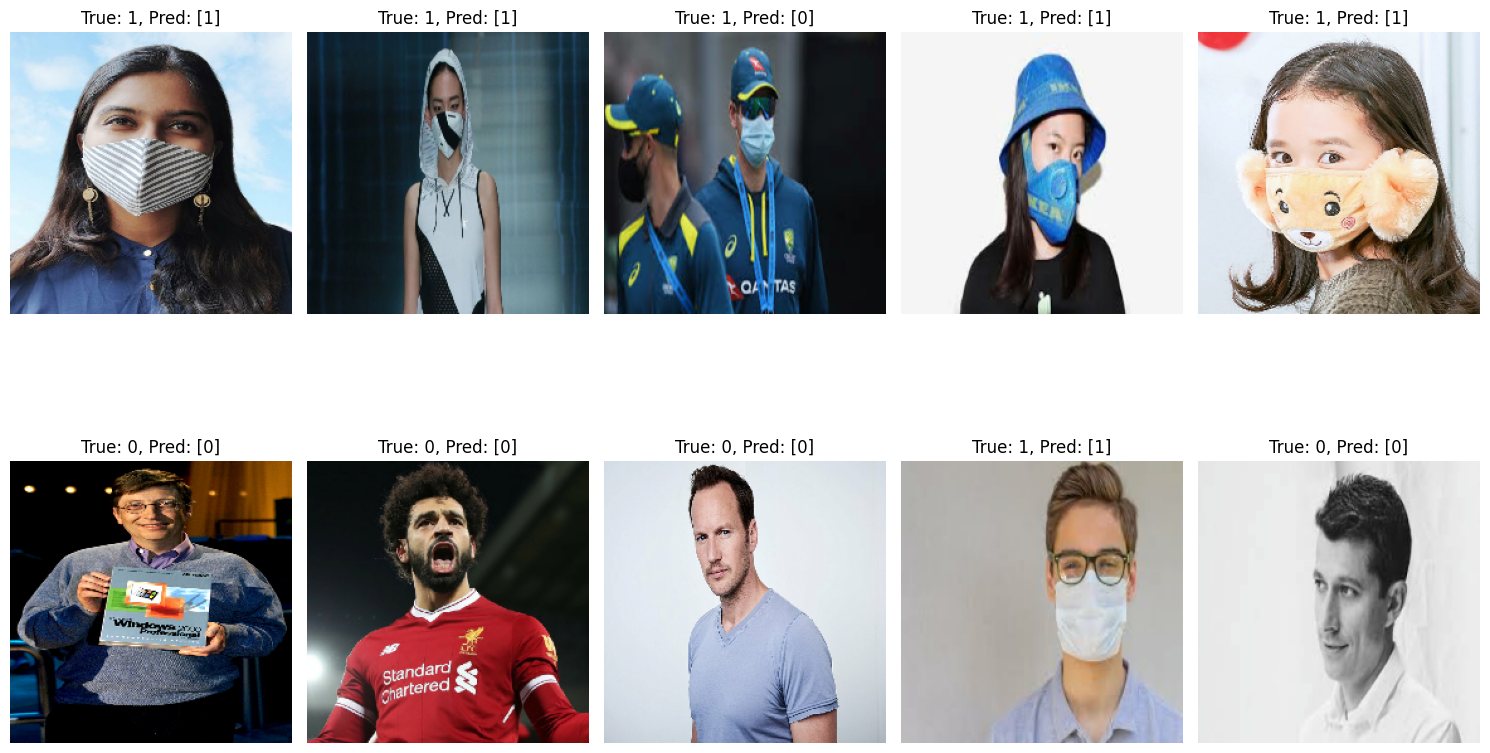

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialize lists to store true labels, predicted labels, and images
true_labels = []
predicted_labels = []
images_batch = []

# Iterate through the testing dataset to collect the first 10 images
for images, labels in testing_dataset:
    # Append the images, true labels
    true_labels.append(labels.numpy())
    images_batch.append(images.numpy())
    
    # Get the model predictions (probabilities)
    predicted_probs = model.predict(images)
    
    # Convert the probabilities to predicted labels (0 or 1)
    predicted_labels_batch = (predicted_probs > 0.5).astype(int)
    predicted_labels.append(predicted_labels_batch)
    

# Flatten the lists of true labels, predicted labels, and images
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)
images_batch = np.concatenate(images_batch, axis=0)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Testing Accuracy: {accuracy * 100:.2f}%")
# Show the first 10 images with their true and predicted labels
plt.figure(figsize=(15, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)  # Arrange images in 2 rows and 5 columns
    rgb_image = undo_preprocess_input(images_batch[i])
    plt.imshow(rgb_image.astype(np.uint8))  # Display the image as uint8
    plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification Report: Precision, Recall, F1-Score
report = classification_report(true_labels, predicted_labels, target_names=["No Mask", "Mask"])
print("Classification Report:")
print(report)




Classification Report:
              precision    recall  f1-score   support

     No Mask       0.99      0.98      0.98       238
        Mask       0.98      0.99      0.98       238

    accuracy                           0.98       476
   macro avg       0.98      0.98      0.98       476
weighted avg       0.98      0.98      0.98       476



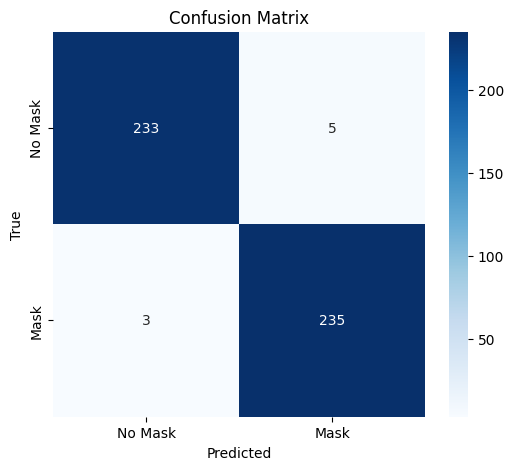

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
model.save("MaskClassification-DenseNet.keras")

In [11]:
import pickle
# Save the history to a file
with open('MaskClassification-DenseNet.pkl', 'wb') as file:
    pickle.dump(history, file)

INFO:tensorflow:Assets written to: ram://4674c942-cf57-4ebe-907b-82dfa6ce578b/assets


INFO:tensorflow:Assets written to: ram://4674c942-cf57-4ebe-907b-82dfa6ce578b/assets
